### 1. Data Preparation
- 설명 : 전자금융홈펌뱅킹을 통해 타행으로 이체 거래내역
- 데이터 : DATOP_HF_TRANS.csv
  - BASE_YM : 기준연월
  - HNDE_BANK_RPTV_CODE : (비식별)취급은행대표코드
  - OPENBANK_RPTV_CODE : (비식별)개설은행대표코드
  - FND_TPCD : 자금구분코드
  - TRAN_AMT : 거래금액
- 데이터수 : 267,241개

In [ ]:
import pandas as pd
import torch
import time

from bleach.callbacks import target_blank

cuda_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'##### Using device: {cuda_device}')

# 실제데이터 이름
data_name = 'DATOP_HF_TRANS'

# 모델 학습에 사용할 실제데이터 수
n_org_samples = 10000  # 1000, 10000, 100000

# 실제데이터 로드
start_time = time.time()
org_datasets = pd.read_csv(f'./org_datasets/{data_name}.csv')
print(f'##### {data_name} Dataset Size: {len(org_datasets)} (we use {n_org_samples})')
org_datasets = org_datasets[:n_org_samples]

print(f'##### Data loading time: {time.time() - start_time:.2f} seconds')

## 2. Prepare Metadata
- 컬럼 종류, 유형(numerical, categorical) 등

In [2]:
from sdv.metadata import SingleTableMetadata
import pprint
import os.path

# 메타데이터 정의
metadata_filename = f'./org_datasets/{data_name}_meta.json'
metadata = SingleTableMetadata()

# 메타데이터 Json 파일 존재여부 확인
if os.path.isfile(metadata_filename):
    metadata = metadata.load_from_json(metadata_filename)
else:
    metadata.detect_from_dataframe(data=org_datasets)
    metadata.update_column(
        column_name='BASE_YM',
        sdtype='datetime',
        datetime_format='%Y%m'
    )
    
    metadata.update_columns(
        column_names=['TRAN_AMT'],
        sdtype='numerical'
    )
    
    metadata.update_columns(
        column_names=['HNDE_BANK_RPTV_CODE', 'OPENBANK_RPTV_CODE', 'FND_TPCD'],
        sdtype='categorical'
    )
    metadata.save_to_json(f'./org_datasets/{data_name}_meta.json')
pprint.pprint(metadata.to_dict())


{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'BASE_YM': {'datetime_format': '%Y%m', 'sdtype': 'datetime'},
             'FND_TPCD': {'sdtype': 'categorical'},
             'HNDE_BANK_RPTV_CODE': {'sdtype': 'categorical'},
             'OPENBANK_RPTV_CODE': {'sdtype': 'categorical'},
             'TRAN_AMT': {'sdtype': 'numerical'}}}


## 3. Training Model

In [17]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer

model_name = 'copula'  # ctgan, tvae, copulagan, copula
if model_name == 'ctgan':
    model = CTGANSynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'tvae':
    model = TVAESynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'copulagan':
    model = CopulaGANSynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'copula':
    model = GaussianCopulaSynthesizer(metadata=metadata)

start_time = time.time()
# 모델 학습
model.fit(org_datasets)
print(f"##### {model_name} training time: {time.time() - start_time:.2f} seconds")


##### copula training time: 3.54 seconds


## 4. Sampling Synthetic Data

In [18]:
# 합성데이터 샘플링
n_syn_samples = 10000  # 10000, 20000, 30000

start_time = time.time()
synthetic_data = model.sample(n_syn_samples)
print(f"##### Total synthetic data generation time: {time.time() - start_time:.2f} seconds")
print(synthetic_data.head())

# 합성데이터 저장
synthetic_data.to_csv(f'./syn_datasets/{data_name}_{model_name}_{n_org_samples}_to_{n_syn_samples}.csv', index=False)

##### Total synthetic data generation time: 0.26 seconds
   BASE_YM HNDE_BANK_RPTV_CODE OPENBANK_RPTV_CODE  FND_TPCD       TRAN_AMT
0   202107                 IEK                CAZ         0   711017598525
1   202107                 ZVX                ZDD         4     1228068292
2   202107                 ZDD                SHK         4  2324089443982
3   202107                 FYT                YCA         0      148996826
4   202107                 MIQ                JVP         0          13782


## 5. Evaluate Synthetic Data
- 유용성 및 노출위험도 관련 지표 확인
- https://github.com/schneiderkamplab/syntheval

SynthEval: synthetic data read successfully


Syntheval: pca:   6%|▌         | 1/17 [00:00<00:03,  4.84it/s]/home/bigdyl/anaconda3/envs/aifinlab/lib/python3.10/site-packages/syntheval/utils/plot_metrics.py:131: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=data[components[i]], hue=data['real'], fill=True, multiple="layer", ax=axs[i, i], palette=['#7FB8D8','#EEC681'])
Syntheval: cio:  12%|█▏        | 2/17 [00:03<00:31,  2.07s/it]/home/bigdyl/anaconda3/envs/aifinlab/lib/python3.10/site-packages/syntheval/metrics/utility/metric_confidence_interval_overlap.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  Jk.append(max(0,0.5*(top/(us[i][0]-ls[i][0])+top/(us[i][1]-ls[i][1]))))
Syntheval: ks_test:  29%|██▉       | 5/17 [00:07<00:19,  1.66s/it]  /home/bigdyl/anaconda3/envs/aifinlab/lib/python3.10/site-packages/syntheval/utils/plot_metrics.py:156: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  pl

Error: AUROC metric did not run, analysis target variable did not have appropriate number levels (i.e. 2) or test data was not supplied!



Syntheval: att_discl:  88%|████████▊ | 15/17 [17:03<03:04, 92.14s/it]

Error: Membership inference attack metric did not run, holdout data was not supplied!


Syntheval: att_discl: 100%|██████████| 17/17 [17:11<00:00, 60.68s/it]


SynthEval results

Utility metric description                    value   error                                 
+---------------------------------------------------------------+
| Average dimensionwise means diff. (nums) :   0.1257  0.0013   |
| PCA difference in eigenvalues (exp. var.):   0.9549           |
| PCA angle between eigenvectors (radians) :   0.7854           |
| Average confidence interval overlap      :   0.3024  0.3024   |
|   -> # non-overlapping COIs at 95%       :    1               |
|   -> fraction of non-overlapping CIs     :   0.5000           |
| Mixed correlation matrix difference      :   nan           |
| Pairwise mutual information difference   :   0.2463           |
| Kolmogorov–Smirnov / Total Variation Distance test            |
|   -> average combined statistic          :   0.1536  0.0921   |
|       -> avg. Kolmogorov–Smirnov dist.   :   0.3486  0.1457   |
|       -> avg. Total Variation Distance   :   0.0236  0.0077   |
|   -> average combined p-value 

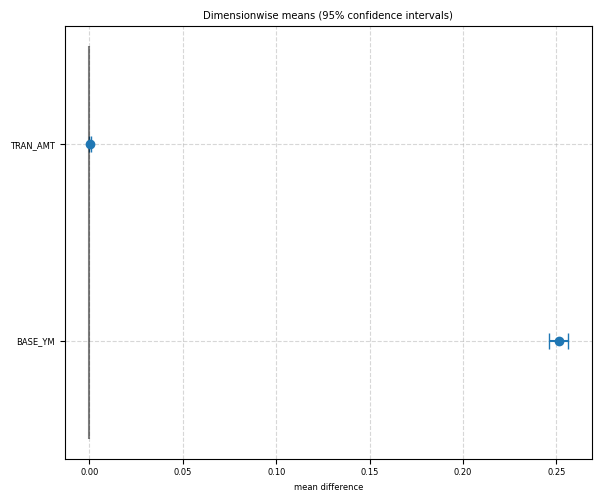

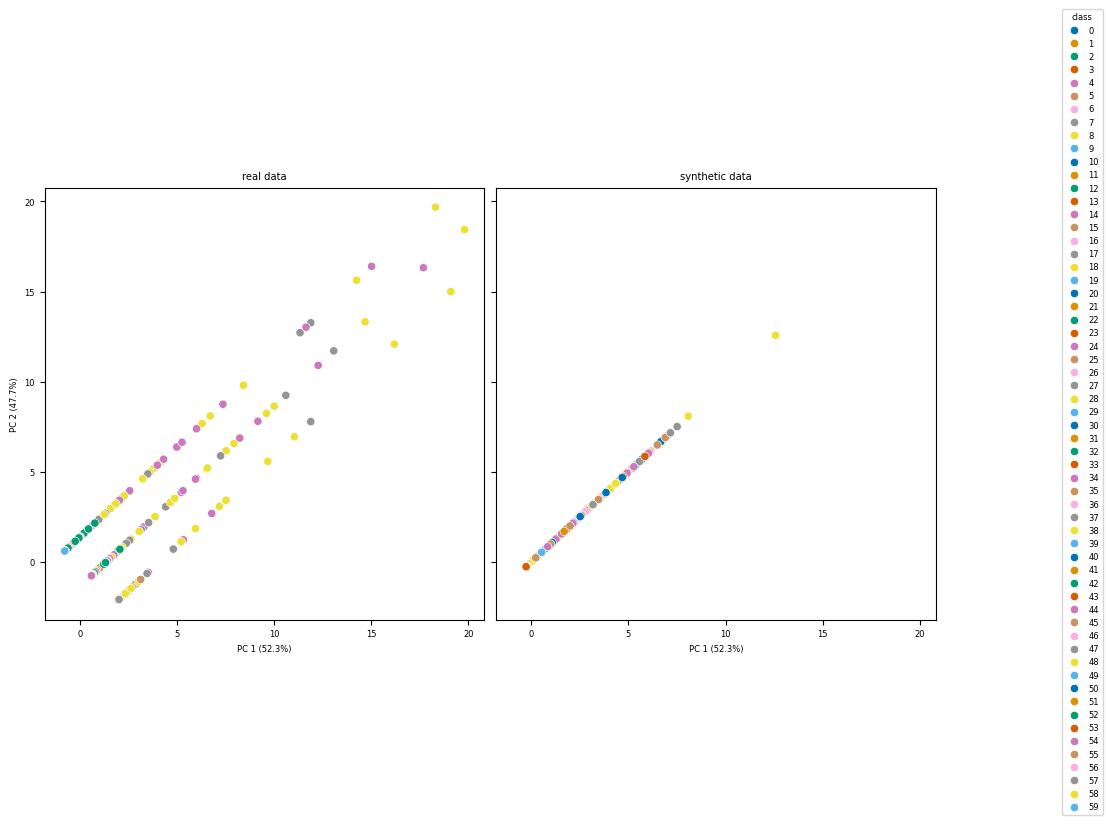

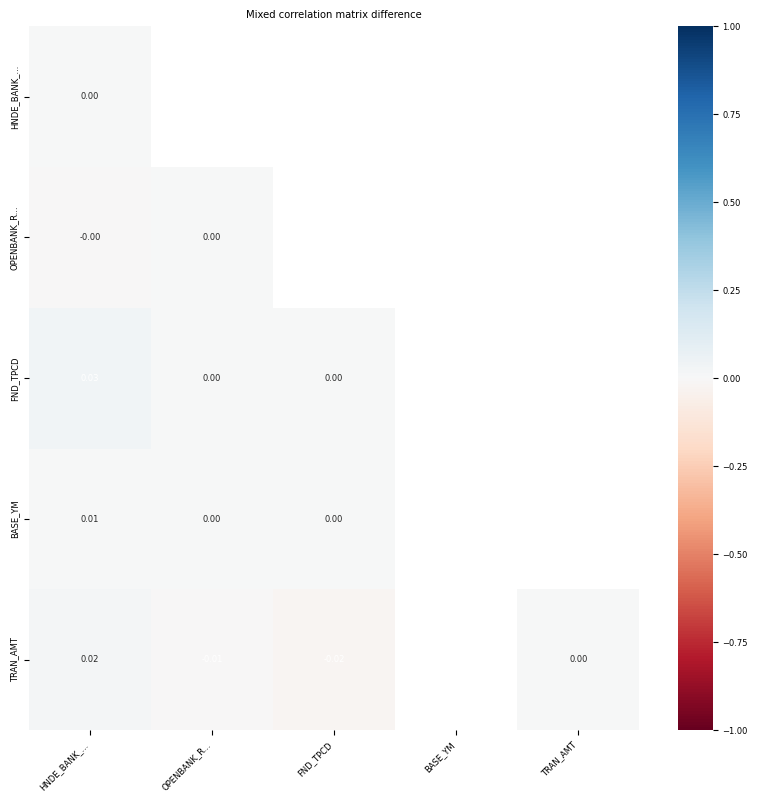

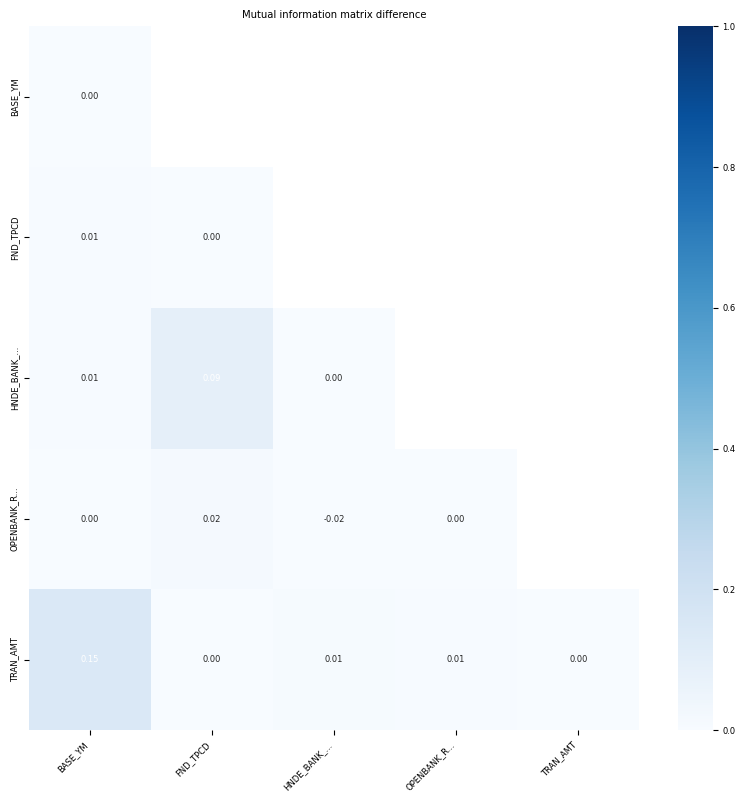

In [19]:
from syntheval import SynthEval
import warnings
warnings.filterwarnings("ignore", message="Creating legend with loc='best'")

# synthetic_data = pd.read_csv(f'./syn_datasets/DATOP_HF_TRANS_ctgan_10000.csv')

categorical_columns = ['HNDE_BANK_RPTV_CODE', 'OPENBANK_RPTV_CODE', 'FND_TPCD']

S = SynthEval(real_dataframe=org_datasets, cat_cols=categorical_columns)
analysis_target_var = 'HNDE_BANK_RPTV_CODE' # for PCA
results = S.evaluate(synthetic_dataframe=synthetic_data, presets_file='full_eval', analysis_target_var=analysis_target_var)

print('##### Results Dataframe')
print(results)

results.to_csv(f'./evaluation/hf_trans/{n_org_samples}_to_{n_syn_samples}/{model_name}/eval_metrics.csv', index=False)
